In [1]:

%load_ext autoreload
%autoreload 2

In [57]:
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from imview import pltlib
import pandas as pd
from pygeotools.lib import warplib,geolib,iolib,malib,filtlib,timelib
import os,sys,glob,shutil
from debris_cover_smb import glac_dyn, constants, geospatial
import warnings
from demcoreg import dem_mask
from scipy.optimize import curve_fit
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

## Relationship between slope and residual dh uncertainty
* I could not find a relationship between raw dh and slope pixels (signed or unsigned), see 2d-Histogram
* I reverted to binning, in the end, I bin the un-signed Dh uncertainty in 2 degree slope bins
* For each bin, I compute the median slope-corrected lag Dh/Dt uncertainty
* A exponential function is fit to the bin-wise uncertainty metric
* The function is used to model uncertainty over Glacier surface using the slope map over glacier surface
* Question: I probably need a better function to fit to, as I can see the optimized functions under-predicts the uncertainty at low slope values

In [4]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Ngozumpa/SMB_data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Ngozumpa/SMB_data


In [5]:
dem1_fn = '../dem/20121223_0456_1050410000E0AE00_1050410000E8C900-DEM_2m.tif'
dem2_fn = '../dem/20150115_0456_1040010006A12900_104001000665F400-DEM_2m_align.tif'
vx_fn = '20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif'
vy_fn = '20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip.tif'
smb_fn = 'ngozumpa_farinotti_2012-12-23_to_2015-01-15_smb_dhdt.tif'
ds_list_highres = warplib.memwarp_multi_fn([dem1_fn,dem2_fn,vx_fn,vy_fn,smb_fn])
dem1,dem2,vx_highres,vy_highres,smb = [iolib.ds_getma(ds) for ds in ds_list_highres]


Warping all inputs to the following:
Resolution: 2.0
Extent: [464833.0, 3085323.0, 477631.0, 3104071.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 5: ../dem/20121223_0456_1050410000E0AE00_1050410000E8C900-DEM_2m.tif
nl: 9374 ns: 6399 res: 2.000
0...10...20...30...40...50...60...70...80...90...2 of 5: ../dem/20150115_0456_1040010006A12900_104001000665F400-DEM_2m_align.tif
nl: 9374 ns: 6399 res: 2.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 5: 20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif
4 of 5: 20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip.tif
5 of 5: ngozumpa_farinotti_2012-12-23_to_2015-01-15_smb_dhdt.tif
nl: 9374 ns: 6399 res: 2.000
100 - done.
0...10...20...30...40...50...60...70...80...90...

In [6]:
icemask = dem_mask.get_icemask(ds_list_highres[0])

Masking glaciers
Found glacier shp: /nobackupp11/sbhusha1/reference_data/rgi60/regions/rgi60_merge.shp
Input shp srs: +proj=longlat +datum=WGS84 +no_defs
Specified output srs: +proj=utm +zone=45 +datum=WGS84 +units=m +no_defs


In [7]:
res_high = geolib.get_res(ds_list_highres[0])[0]
dt = timelib.get_t_factor_fn(dem1_fn,dem2_fn)

In [8]:
lag_dhdt = glac_dyn.compute_lagrangian(dem1,dem2,vx_highres,vy_highres,dt,annual=True,res=res_high)

In [9]:
slope_parallel_dhdt = glac_dyn.compute_along_slope_flow_correction_working(dem1,vx_highres,vy_highres,dt,annual=True,res=res_high,smooth=False)

In [10]:
slope_corrected_lag_dhdt = lag_dhdt - slope_parallel_dhdt

In [11]:
slope1 = geolib.gdaldem_mem_ma(dem1,ds=ds_list_highres[0],processing='slope',returnma=True,computeEdges=True)

In [12]:
slope1_static = np.ma.array(slope1,mask=~icemask)
slope_corrected_lag_dhdt_static = np.ma.array(slope_corrected_lag_dhdt,mask=~icemask)

<Axes: >

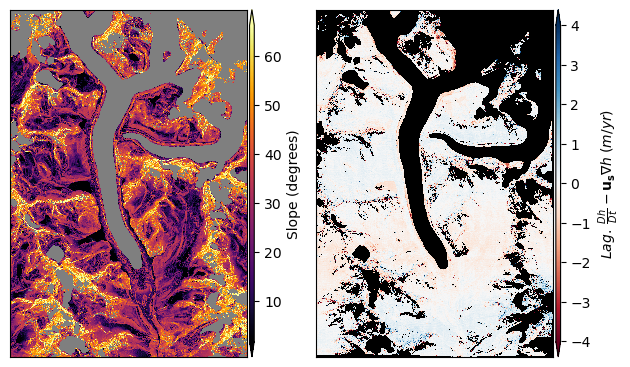

In [13]:
f,ax = plt.subplots(1,2)
pltlib.iv(slope1_static,ax=ax[0],cmap='inferno',label='Slope (degrees)')
pltlib.iv(slope_corrected_lag_dhdt_static,ax=ax[1],cmap='RdBu',clim=(-4,4),label=r'$Lag. \; \frac{Dh}{Dt} - \mathbf{u_{s}}{\nabla h} \; (m/yr)$')

In [14]:
common_mask = malib.common_mask([slope1_static,slope_corrected_lag_dhdt_static])
slope1_1d = np.ma.array(slope1_static,mask=common_mask).compressed()
slope_corrected_lag_dhdt_uncertainty = np.ma.array(slope_corrected_lag_dhdt_static,mask=common_mask).compressed()

In [15]:
def plot_hexbin(x_com,y_com,ax,xlim=None,ylim=None,gridsize=100):
    #c_mask = malib.common_mask([x,y])
    #x = np.ma.array(x,mask=c_mask)
    #y = np.ma.array(y,mask=c_mask)
    #x_com = np.ma.compressed(x)
    #y_com = np.ma.compressed(y)
    if not xlim:
        xlim = np.percentile(x_com,(2,98))
    if not ylim:
        ylim = np.percentile(y_com,(2,98))
    ax.hexbin(x_com,y_com,cmap='inferno',gridsize=gridsize,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[0],ylim[1])

Text(0, 0.5, '$Lag. \\; \\frac{Dh}{Dt} - \\mathbf{u_{s}}{\\nabla h} \\; (m/yr)$')

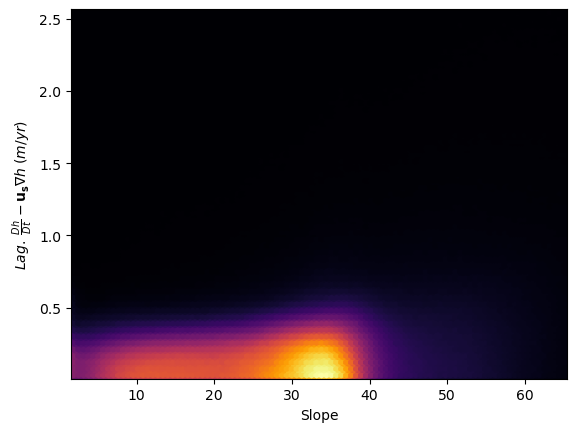

In [20]:
f,ax = plt.subplots()
plot_hexbin(slope1_1d,np.abs(slope_corrected_lag_dhdt_uncertainty),ax)
ax.set_xlabel('Slope')
ax.set_ylabel(r'$Lag. \; \frac{Dh}{Dt} - \mathbf{u_{s}}{\nabla h} \; (m/yr)$')

Text(0, 0.5, '$Lag. \\; \\frac{Dh}{Dt} - \\mathbf{u_{s}}{\\nabla h} \\; (m/yr)$')

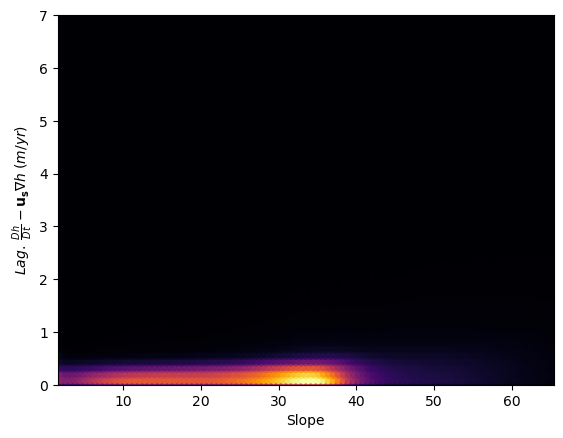

In [32]:
f,ax = plt.subplots()
plot_hexbin(slope1_1d,np.abs(slope_corrected_lag_dhdt_uncertainty),ax,ylim=(0,7))
ax.set_xlabel('Slope')
ax.set_ylabel(r'$Lag. \; \frac{Dh}{Dt} - \mathbf{u_{s}}{\nabla h} \; (m/yr)$')

In [26]:
def slope_aggregator_box(slope,dh_error,slope_lims=(0,50),bin_size=10, signed=True):
    """
    Aggegate dh stats with input slope bins
    Parameters
    -------------
    slope: np.ma.array
        slope map
    dh_error: np.ma.array
        dh map
    slope_lims: tuple
        min/max slope interval over which to compute aggregated stats
    bin_size: int
        bin size for aggregating stats
    Returns
    -------------
    bin_mid: list
        list of tuples with bin middle points
    var_list: list
        arrays of output variable for which to draw boxplots
    """
    mask = malib.common_mask([slope,dh_error])
    slope = np.ma.array(slope,mask=mask)
    if signed:
        dh_error = np.ma.array(dh_error,mask=mask)
        #dh_error = dh_error
    else:
        #dh_error = np.abs(dh_error)
        dh_error = np.ma.abs(np.ma.array(dh_error,mask=mask))
    slope_intervals = np.arange(slope_lims[0],slope_lims[1]+3,bin_size)
    
    var_list = []
    bin_mid = []
    total_count = dh_error.count()
    for idx in range(len(slope_intervals)-1):
        min_slope = slope_intervals[idx]
        max_slope = slope_intervals[idx+1]
        bin_mid.append((max_slope+min_slope)/2)
        
        slope_idx = (slope >= min_slope) & (slope <= max_slope)
        error = dh_error[slope_idx]
        error=np.ma.fix_invalid(error)
        var_list.append(error.compressed())
        
    return (bin_mid, var_list)

In [27]:
slope_lims = (0,50)
mid_val, var_list = slope_aggregator_box(slope1_static, slope_corrected_lag_dhdt_static, slope_lims=slope_lims) 


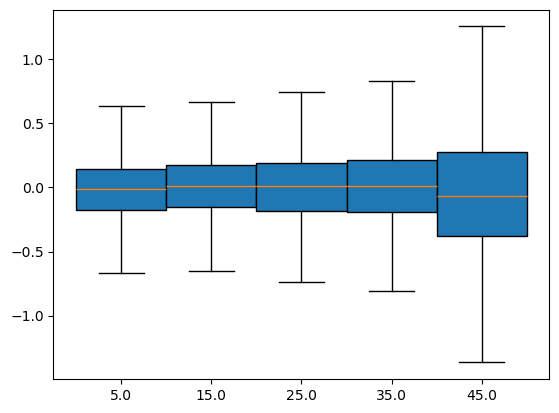

In [29]:
f,ax= plt.subplots()
boxwidth = 10
box_test = ax.boxplot(var_list, positions=mid_val, sym='', widths=boxwidth, patch_artist=True)

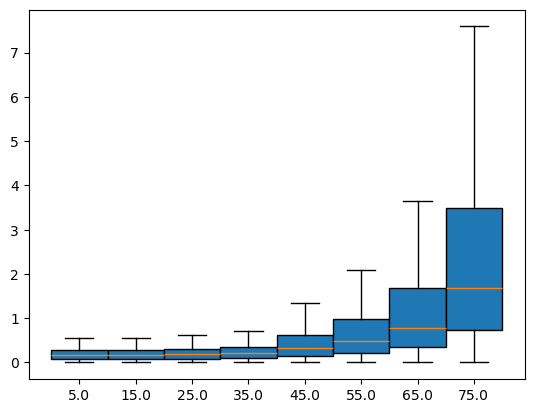

In [31]:
f,ax= plt.subplots()
boxwidth = 10
slope_lims = (0,80)
mid_val, var_list = slope_aggregator_box(slope1_static, slope_corrected_lag_dhdt_static, slope_lims=slope_lims,signed=False) 
box_test = ax.boxplot(var_list, positions=mid_val, sym='', widths=boxwidth, patch_artist=True)

In [33]:
slope_glacier = np.ma.array(slope1,mask=icemask)

In [36]:
malib.calcperc(slope_glacier,(0.01,0.99))

(0.09891160577535629, 1.1416258811950684)

In [37]:
np.percentile(slope_glacier.compressed(),99)

59.712494735717776

[Text(0, 0, '0'),
 Text(5, 0, '5'),
 Text(10, 0, '10'),
 Text(15, 0, '15'),
 Text(20, 0, '20'),
 Text(25, 0, '25'),
 Text(30, 0, '30'),
 Text(35, 0, '35'),
 Text(40, 0, '40'),
 Text(45, 0, '45'),
 Text(50, 0, '50'),
 Text(55, 0, '55'),
 Text(60, 0, '60')]

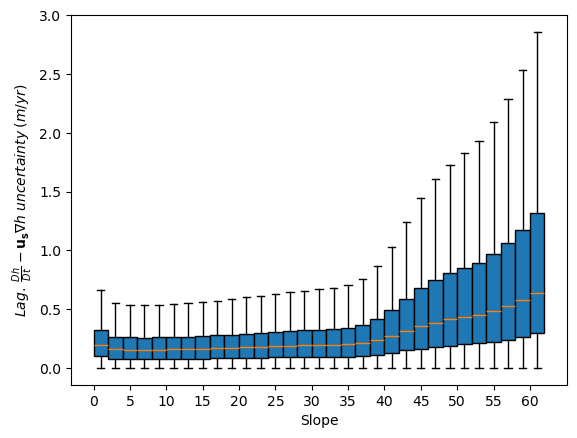

In [48]:
f,ax= plt.subplots()
boxwidth = 2
binsize = 2
slope_lims = (0,60)
mid_val, var_list = slope_aggregator_box(slope1_static, slope_corrected_lag_dhdt_static, slope_lims=slope_lims,signed=False,bin_size=binsize) 
box_test = ax.boxplot(var_list, positions=mid_val, sym='', widths=boxwidth, patch_artist=True)
ax.set_xlabel('Slope')
ax.set_ylabel(r'$Lag. \; \frac{Dh}{Dt} - \mathbf{u_{s}}{\nabla h} \; uncertainty \; (m/yr)$')
#ax.setxticks(np.arange(slope_lims[0],slope_lims[1],5))
ax.set_xticks(np.arange(slope_lims[0],slope_lims[1]+5,5))
ticks = np.arange(slope_lims[0],slope_lims[1]+5,5)
ax.set_xticklabels(ticks,ha='center')

In [51]:
median_error = [np.ma.median(v) for v in var_list]

In [53]:
len(mid_val)

31

In [54]:
len(median_error)

31

In [102]:
def exp_function(x,a,b):
    return a * np.exp(-b * x)

In [89]:
type(median_error[0])

numpy.float32

In [103]:
popt, pcov = curve_fit(exp_function, np.array(mid_val), np.array(median_error))

In [91]:
popt

array([ 0.08928143, -0.0307946 ])

In [104]:
result = exp_function(np.array(mid_val),popt[0],popt[1])

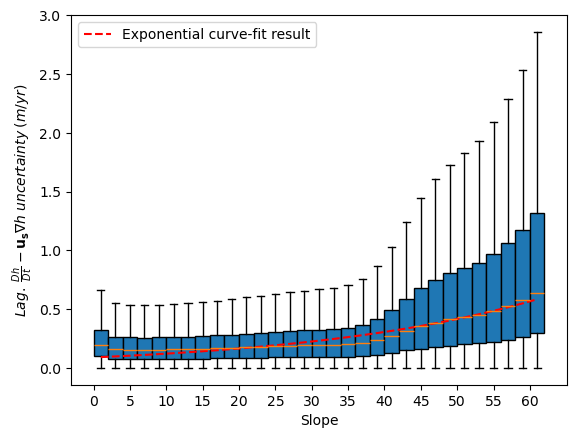

In [135]:

f,ax= plt.subplots()
boxwidth = 2
binsize = 2
slope_lims = (0,60)
mid_val, var_list = slope_aggregator_box(slope1_static, slope_corrected_lag_dhdt_static, slope_lims=slope_lims,signed=False,bin_size=binsize) 
box_test = ax.boxplot(var_list, positions=mid_val, sym='', widths=boxwidth, patch_artist=True)
ax.set_xlabel('Slope')
ax.set_ylabel(r'$Lag. \; \frac{Dh}{Dt} - \mathbf{u_{s}}{\nabla h} \; uncertainty \; (m/yr)$')
#ax.setxticks(np.arange(slope_lims[0],slope_lims[1],5))
ax.set_xticks(np.arange(slope_lims[0],slope_lims[1]+5,5))
ticks = np.arange(slope_lims[0],slope_lims[1]+5,5)
ax.set_xticklabels(ticks,ha='center')
ax.plot(mid_val,result,linestyle='--',c='red',label='Exponential curve-fit result')
ax.legend()

In [93]:
result

array([0.09207359, 0.0979226 , 0.10414317, 0.1107589 , 0.1177949 ,
       0.12527786, 0.13323618, 0.14170006, 0.1507016 , 0.16027497,
       0.1704565 , 0.18128481, 0.19280099, 0.20504874, 0.21807454,
       0.2319278 , 0.2466611 , 0.26233033, 0.27899496, 0.29671822,
       0.31556735, 0.33561388, 0.35693387, 0.37960822, 0.40372297,
       0.42936961, 0.45664547, 0.48565404, 0.51650538, 0.54931657,
       0.5842121 ])

In [106]:
dh_error_glacier = exp_function(slope_glacier,popt[0],popt[1])

<Axes: >

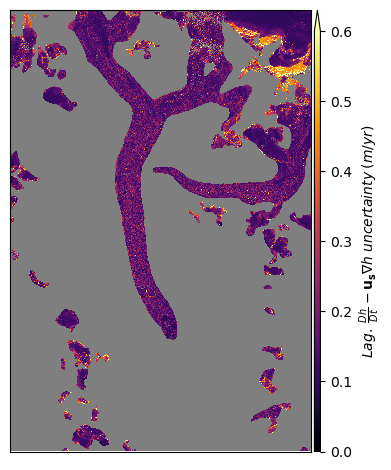

In [133]:
f,ax = plt.subplots()
pltlib.iv(dh_error_glacier,ax=ax,cmap='inferno',label=r'$Lag. \; \frac{Dh}{Dt} - \mathbf{u_{s}}{\nabla h} \; uncertainty \; (m/yr)$',clim=(0,0.6))

In [134]:
malib.get_stats_dict(dh_error_glacier)

{'count': 14313643,
 'min': 0.08928143233060837,
 'max': 1.2284598350524902,
 'ptp': 1.1391783952713013,
 'mean': 0.1833951077607315,
 'std': 0.09507447644916175,
 'nmad': 0.05919704906791448,
 'med': 0.15655499696731567,
 'median': 0.15655499696731567,
 'p16': 0.11204545944929123,
 'p84': 0.24302901327610016,
 'spread': 0.06549177691340446,
 'mode': 0.0910719558596611}

## From XDEM method
* https://xdem.readthedocs.io/en/stable/spatialstats.html
* This method bins per-slope, and then compute NMAD of signed values in each slope bin
* Then a function is fit to the observed slope-NMAD relationship

In [108]:
import xdem

In [111]:
df_ns = xdem.spatialstats.nd_binning(
    np.ma.filled(slope_corrected_lag_dhdt_static,np.nan), list_var=[np.ma.filled(slope1_static,np.nan)], list_var_names=["slope"], statistics=["count", xdem.spatialstats.nmad]
)

In [112]:
df_ns

,nd,count,nmad,slope
0,1,3850378.0,0.243696,"[0.0, 8.562463760375977)"
1,1,5320259.0,0.237376,"[8.562463760375977, 17.124927520751953)"
2,1,6052276.0,0.260902,"[17.124927520751953, 25.687389373779297)"
3,1,8985949.0,0.286887,"[25.687389373779297, 34.249855041503906)"
4,1,7015446.0,0.331834,"[34.249855041503906, 42.81231689453125)"
5,1,2721528.0,0.543225,"[42.81231689453125, 51.374778747558594)"
6,1,2100570.0,0.676661,"[51.374778747558594, 59.9372444152832)"
7,1,1235945.0,1.037640,"[59.9372444152832, 68.49971008300781)"
8,1,394816.0,2.068257,"[68.49971008300781, 77.06217193603516)"
9,1,20199.0,5.642937,"[77.06217193603516, 85.6246337890625)"


In [113]:
err_dh = xdem.spatialstats.interp_nd_binning(df_ns, list_var_names=["slope"])

In [116]:
glacier_error = err_dh(slope_glacier.compressed())

In [119]:
malib.get_stats_dict(glacier_error)

{'count': 14313643,
 'min': 0.23737555842312555,
 'max': 5.642936778116228,
 'ptp': 5.405561219693102,
 'mean': 0.29137644916173056,
 'std': 0.15236023498299783,
 'nmad': 0.01857951745170716,
 'med': 0.2521957260416084,
 'median': 0.2521957260416084,
 'p16': 0.24028930315227437,
 'p84': 0.300271157712244,
 'spread': 0.029990927279984814,
 'mode': 0.24369619971513745}

In [124]:
glacier_error = err_dh(np.ma.filled(np.ma.reshape(slope_glacier,(slope_glacier.size,1)),np.nan))

In [128]:
glacier_uncertainty_reshape = np.ma.fix_invalid(np.reshape(glacier_error,slope_glacier.shape))

In [129]:
malib.get_stats_dict(glacier_uncertainty_reshape)

{'count': 14313643,
 'min': 0.23737555842312555,
 'max': 5.642936778116228,
 'ptp': 5.405561219693102,
 'mean': 0.29137644916173105,
 'std': 0.15236023498299772,
 'nmad': 0.01857951745170716,
 'med': 0.2521957260416084,
 'median': 0.2521957260416084,
 'p16': 0.24028930315227437,
 'p84': 0.300271157712244,
 'spread': 0.029990927279984814,
 'mode': 0.24369619971513745}

<Axes: >

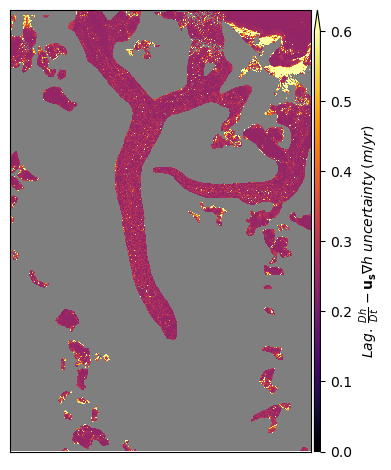

In [131]:
f,ax = plt.subplots()
pltlib.iv(glacier_uncertainty_reshape,ax=ax,cmap='inferno',clim=(0,0.6),label=r'$Lag. \; \frac{Dh}{Dt} - \mathbf{u_{s}}{\nabla h} \; uncertainty \; (m/yr)$')